_This notebook contains code and comments from Sections 4.1 and 4.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 4.1 Sequential Ensembles of Weak Learners
Decision stumps (trees of depth 1, left) are commonly used as weak learners in sequential ensemble methods such as boosting. As tree depth increases, it becomes a stronger classifier, and its performance improves. However, it is not possible to arbitrarily increase the strength of classifiers as they will begin to overfit during training, which decreases their prediction performance when deployed.

Below, we visualize the decision boundaries of a weak tree and a strong tree. 

In [2]:
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from visualization import plot_2d_classifier

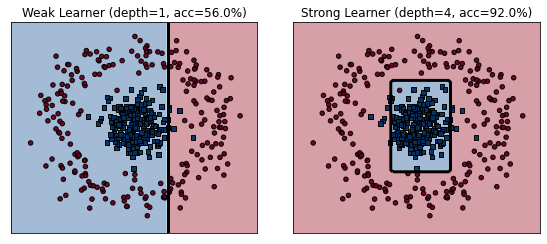

In [13]:
%matplotlib inline

# Generate the data
X, y = make_circles(n_samples=500, noise=0.15, factor=0.2)
X, Xtst, y, ytst = train_test_split(X, y, train_size=450)

# Train the classifiers
weak_learner = DecisionTreeClassifier(max_depth=1)
weak_learner.fit(X, y)
weak_learner_err = accuracy_score(ytst, weak_learner.predict(Xtst))

strong_learner = DecisionTreeClassifier(max_depth=4)
strong_learner.fit(X, y)
strong_learner_err = accuracy_score(ytst, strong_learner.predict(Xtst))

# Plot the two trees
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))


title = 'Weak Learner (depth=1, acc={0:3.1f}%)'.format(100 * weak_learner_err)
plot_2d_classifier(ax[0], X, y, predict_function=weak_learner.predict, 
                   alpha=0.4, xlabel=None, ylabel=None, 
                   title=title, colormap='RdBu')
ax[0].set_xticks([])
ax[0].set_yticks([])

title = 'Strong Learner (depth=4, acc={0:3.1f}%)'.format(100 * strong_learner_err)
plot_2d_classifier(ax[1], X, y, predict_function=strong_learner.predict, 
                   alpha=0.4, xlabel=None, ylabel=None, 
                   title=title, colormap='RdBu')
ax[1].set_xticks([])
ax[1].set_yticks([])


fig.tight_layout()
plt.savefig('./figures/CH04_F02_Kunapuli.png', dpi=300, bbox_inches='tight', pad_inches=0)

---

## 4.2 AdaBoost: Adaptive Boosting
AdaBoost is an adaptive algorithm: at every iteration, it trains a new base estimator that fixes the mistakes made by the previous base estimator. Thus, it needs some way to ensure that the base learning algorithm prioritizes misclassified training examples. AdaBoost does this by maintaining weights over individual training examples. 

### 4.2.1 Intuition: Learning with Weighted Examples

Let’s visualize the first few iterations of boosting. Each iteration performs the same steps:
1.	train a weak learner (here, a decision stump) that learns a model to ensure training examples with higher weights are prioritized;
2.	update the weights of the training examples such that misclassified examples are assigned higher weights; the worse the error, the higher the weight.

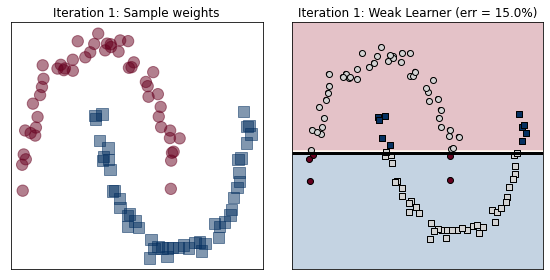

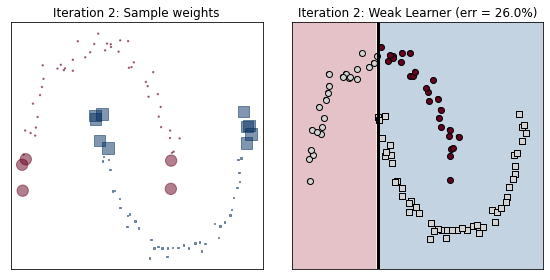

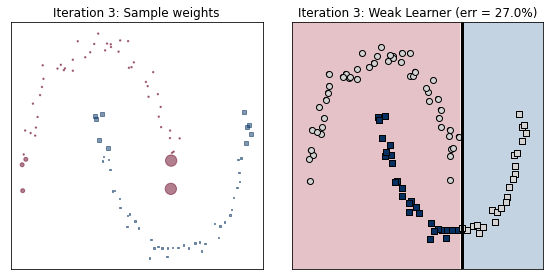

In [71]:
%matplotlib inline

import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from visualization import get_colors

X, y = make_moons(n_samples=100, noise=0.05)
y = 2 * y - 1  # Convert labels from [0, 1] to [-1, 1]

n_samples, n_features = X.shape
n_estimators = 3                                # Set the number of weak learners in the ensemble
D = np.ones((n_samples, ))                      # Initialize example weights
ensemble = []                                   # Initialize an empty ensemble
cm = get_colors(colormap='RdBu', n_colors=2)

for t in range(n_estimators):
    # -- Initialize plotting
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    # --

    D = D / np.sum(D)                           # Normalize the sample weights

    # -- Plot the training examples in different sizes proportional to their weights
    s = D / np.max(D)
    s[(0.00 <= s) & (s < 0.25)] = 2
    s[(0.25 <= s) & (s < 0.50)] = 16
    s[(0.50 <= s) & (s < 0.75)] = 64
    s[(0.75 <= s) & (s <= 1.00)] = 128

    ax[0].scatter(X[y <= 0, 0], X[y <= 0, 1], s=s[y <= 0], marker='o', c=cm[0], edgecolors=None, alpha=0.5)
    ax[0].scatter(X[y > 0, 0], X[y > 0, 1], s=s[y > 0], marker='s', c=cm[1], edgecolors=None, alpha=0.5)
    ax[0].set_title('Iteration {0}: Sample weights'.format(t + 1))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # --

    h = DecisionTreeClassifier(max_depth=1)  # Initialize a decision stump
    h.fit(X, y, sample_weight=D)                # Train a weak learner using sample weights
    ypred = h.predict(X)                        # Predict using the weak learner

    # -- Plot the individual weak learner
    err = (1 - accuracy_score(y, ypred)) * 100
    title = 'Iteration {0}: Weak Learner (err = {1:3.1f}%)'.format(t + 1, err)
    plot_2d_classifier(ax[1], X, y, predict_function=h.predict, 
                       alpha=0.25, xlabel=None, ylabel=None, 
                       title=title, colormap='RdBu')

    pos_err = (y > 0) & (y != ypred)
    pos_cor = (y > 0) & (y == ypred)
    neg_err = (y <= 0) & (y != ypred)
    neg_cor = (y <= 0) & (y == ypred)
    ax[1].scatter(X[neg_err, 0], X[neg_err, 1], marker='o', c=cm[0], edgecolors='k')
    ax[1].scatter(X[neg_cor, 0], X[neg_cor, 1], marker='o', c='lightgray', edgecolors='k')
    ax[1].scatter(X[pos_err, 0], X[pos_err, 1], marker='s', c=cm[1], edgecolors='k')
    ax[1].scatter(X[pos_cor, 0], X[pos_cor, 1], marker='s', c='lightgray', edgecolors='k')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # --

    e = 1 - accuracy_score(y, ypred, sample_weight=D)   # Weighted error of the weak learner
    a = 0.5 * np.log((1 - e) / e)                       # Weak learner weight

    m = (y == ypred) * 1 + (y != ypred) * -1    # Identify correctly classified and misclassified points
    D *= np.exp(-a * m)                         # Update the sample weights

    ensemble.append((a, h))                     # Save the weighted weak hypothesis


    # Save the figure
    fig.tight_layout()
    pngFile = './figures/CH04_F0{0}_Kunapuli.png'.format(t + 3)
    plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

After three iterations, we can combine the three individual weak learners into a strong learner. We next visualize this is the boosted ensemble. We define a function ``predict_boosting`` here to make predictions using this boosted ensemble. However, we will revisit this function more formally in Section 4.2 below.

In [69]:
def predict_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for a, h in estimators:
        pred += a * h.predict(X)
    y = np.sign(pred)

    return y

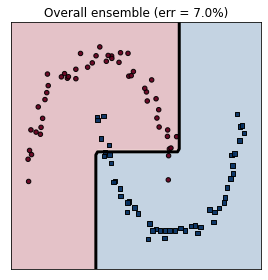

In [72]:
%matplotlib inline

ypred = predict_boosting(X, ensemble)
err = (1 - accuracy_score(y, ypred)) * 100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plot_2d_classifier(ax, X, y, predict_function=predict_boosting, predict_args=(ensemble), 
                   boundary_level=[0.0], alpha=0.25, xlabel=None, ylabel=None, 
                   title=title, colormap='RdBu')

ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
ax.set_title('Overall ensemble (err = {0:3.1f}%)'.format(err))

pngFile = './figures/CH04_F06_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 4.2.2	Implementing AdaBoost

AdaBoost is fairly straightforward to implement. The basic algorithmic outline at the t-th iteration can be described by the following steps:
1. Train a weak learner $h_t (x)$ using the weighted training examples, $(x_i,y_i,D_i)$
	1. Compute the training error $\epsilon_t$ of the weak learner $h_t(x)$
	2. Compute the weight of the weak learner $\alpha_t$ that depends on $\epsilon_t$
     
2. Update the weights of the training examples
    1. Increase the weight of misclassified examples to $D_i e^{\alpha_t}$  
    2. Decrease the weight of correctly classified examples to $D_i⁄e^{\alpha_t}$

At the end of $T$ iterations, we have weak learners $h_t$ along with the corresponding weak learner weights $\alpha_t$. The overall classifier after t iterations is just a weighted ensemble: 

\\[ H(x)= \sum_{t=1}^T \alpha_t  h_t (x). \\]

Two key questions we now need to answer are: (1) how do we update the weights on the training examples, $D_i$; and (2) how do we compute the weight of each base estimator, $\alpha_t$? 

#### Weak Learner Weights ($\alpha_t$)
At each iteration $t$, we obtain a base estimator $h_t(x)$. The training error $\epsilon_t$ of $h_t(x)$ is a measure of its performance. AdaBoost computes its weight as 

\\[ \alpha_t = \frac{1}{2}  \log⁡ \frac{(1-\epsilon_t)}{\epsilon_t}. \\] 

Why this particular formulation? Let’s look at the relationship between $\alpha_t$ and the error $\epsilon_t$. 

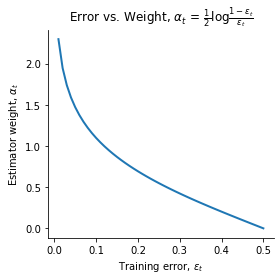

In [79]:
epsilon = np.linspace(0.01, 0.5, num=50)
alpha = 0.5 * np.log((1 - epsilon) / epsilon)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ax.plot(epsilon, alpha, linewidth=2)
ax.set_xlabel('Training error, $\\epsilon_t$')
ax.set_ylabel('Estimator weight, $\\alpha_t$')
ax.set_title('Error vs. Weight, $\\alpha_t \\, = \\, \\frac{1}{2} \\log{\\frac{1 - \\epsilon_t}{\\epsilon_t}}$')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()
pngFile = './figures/CH04_F07_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

#### Training Example Weights ($D_i$)

The base estimator weight ($\alpha_t$) can also be used to update the weights of each training example. AdaBoost updates example weights as

\\[ D_i^{t+1} \, = \, D_i^t \cdot \left\{ \right. \begin{array}{cl} e^{\alpha_t} & \textrm{if misclassified,} \\  e^{-\alpha_t} & \textrm{if correctly classified.} \end{array} \\]

For example, let's say we have two training examples $x_1$ and $x_2$, both with weights $D_1 = D_2 = 0.75$. The current weak learner $h_t$ has weight $\alpha_t = 1.5$. $x_1$ is **correctly classified**, so its **weight should decrease** by a factor of $e^{\alpha_t}$.

In [84]:
D1 = 0.75
alpha_t = 1.5

new_D1 = D1 / np.exp(alpha_t)
print(new_D1)

0.16734762011132237


Conversely, $x_2$ is **misclassified**, so its weight should **increase** by a factor of $e^{\alpha_t}$.

In [85]:
D2 = 0.75
alpha_t = 1.5

new_D2 = D2 * np.exp(alpha_t)
print(new_D2)

3.3612668027535486


#### Training with AdaBoost

**Listing 4.1**: Training an ensemble of weak learners using AdaBoost

This listing is essentially the same listing that was used to generate the figures for Section 4.1.1, but with the plotting code removed.

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def fit_boosting(X, y, n_estimators=10):
    n_samples, n_features = X.shape
    D = np.ones((n_samples, ))
    estimators = []

    for t in range(n_estimators):
        D = D / np.sum(D)                   

        h = DecisionTreeClassifier(max_depth=1)  
        h.fit(X, y, sample_weight=D)        

        ypred = h.predict(X)   
        e = 1 - accuracy_score(y, ypred, sample_weight=D)  
        a = 0.5 * np.log((1 - e) / e)               

        m = (y == ypred) * 1 + (y != ypred) * -1    
        D *= np.exp(-a * m)
                 
        estimators.append((a, h))  

    return estimators

**Listing 4.2**: Making predictions with AdaBoost

This listing is exactly the same listing that was used to generate the figure for the final boosting ensemble for Section 4.1.1 above, and is replicated here again. 

In [96]:
def predict_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for a, h in estimators:
        pred += a * h.predict(X)

    y = np.sign(pred)

    return y

Let us see how this works on a simple, synthetic data set.

**NOTE**: The boosting algorithm we have implemented requires negative examples and positive examples to be labeled -1 and 1 respectively. In the example above, since the function make_moons returns labels y with negative examples and positive examples labeled 0 and 1 respectively, we convert them to -1 and 1 with ``y = (2 * y) – 1``. 

In [97]:
X, y = make_moons(n_samples=200, noise=0.1)
y  = (2 * y) - 1 
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)

In [98]:
estimators = fit_boosting(Xtrn, ytrn)
ypred = predict_boosting(Xtst, estimators)

from sklearn.metrics import accuracy_score
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.06000000000000005

Finally, we visualize the performance of AdaBoost as the number of base estimators increases in the figure below. As we add more and more weak learners into the mix, the overall ensemble is increasingly boosted into a stronger, more complex and more nonlinear classifier.

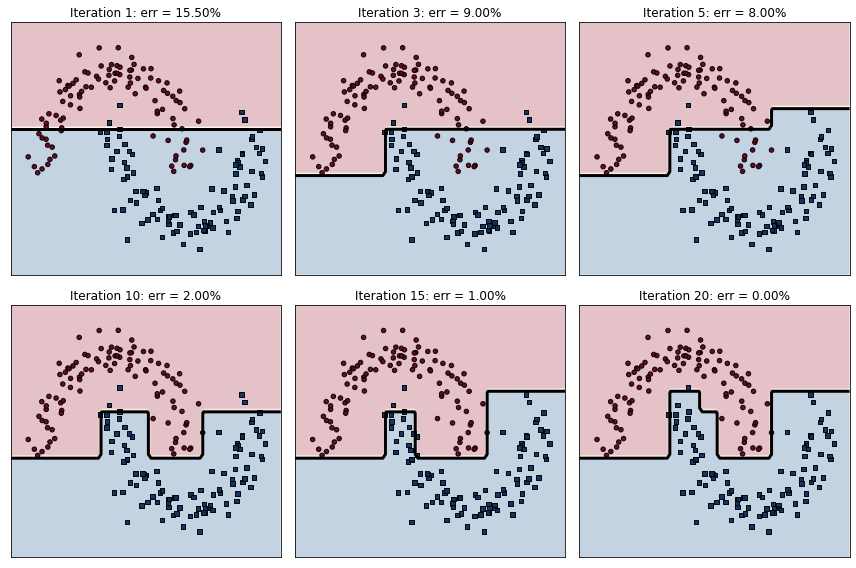

In [104]:
%matplotlib inline

X, y = make_moons(n_samples=200, noise=0.125)
y = 2 * y - 1

n_samples, n_features = X.shape
n_estimators = 20
D = np.ones((n_samples, ))                      # Initialize example weights
ensemble = []                                   # Initialize an empty ensemble

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
subplot_id = -1
for t in range(n_estimators):
    D = D / np.sum(D)                           # Normalize the sample weights

    h = DecisionTreeClassifier(max_depth=1)  # Initialize a decision stump
    h.fit(X, y, sample_weight=D)  # Train a weak learner using sample weights

    ypred = h.predict(X)  # Predict using the weak learner
    e = 1 - accuracy_score(y, ypred, sample_weight=D)   # Weighted error of the weak learner
    a = 0.5 * np.log((1 - e) / e)               # Weak learner weight

    m = (y == ypred) * 1 + (y != ypred) * -1    # Identify correctly classified and misclassified points
    D *= np.exp(-a * m)                         # Update the sample weights

    ensemble.append((a, h))                     # Save the weighted weak hypothesis

    # Plot the ensemble
    if t in [0, 2, 4, 9, 14, 19]:
        subplot_id += 1
        r, c = np.divmod(subplot_id, 3)
        err = (1 - accuracy_score(y, predict_boosting(X, ensemble))) * 100

        title = 'Iteration {0}: err = {1:4.2f}%'.format(t + 1, err)
        plot_2d_classifier(ax[r, c], X, y, 
                           predict_function=predict_boosting, predict_args=ensemble,
                           alpha=0.25, xlabel=None, ylabel=None, 
                           title=title, colormap='RdBu')
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        
fig.tight_layout()
pngFile = './figures/CH04_F09_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 4.2.3	AdaBoost with scikit-learn

``scikit-learn``’s [``AdaBoostClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) provides additional functionality including support for multi-class classification, as well as other base learning algorithms beyond decision trees. There are three important arguments that the AdaBoostClassifier package takes:
* ``base_estimator``, the base learning algorithm AdaBoost uses to train weak learners,
* ``n_estimators``, the number of weak learners that will be trained sequentially by AdaBoost, and
* ``learning_rate``, an additional parameter that progressively shrinks the contribution of each successive weak learner


In [110]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)

In [111]:
shallow_tree = DecisionTreeClassifier(max_depth=2)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                              n_estimators=20, learning_rate=0.75)
ensemble.fit(Xtrn, ytrn)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.75, n_estimators=20)

In [112]:
ypred = ensemble.predict(Xtst)
err = 1 - accuracy_score(ytst, ypred)
print(err)

0.020979020979020935


``AdaBoostClassifier`` also contains a multi-class implementation of AdaBoost called SAMME.

In [115]:
from sklearn.datasets import load_iris
from sklearn.utils.multiclass import unique_labels
X, y = load_iris(return_X_y=True)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)

unique_labels(y)

array([0, 1, 2])

In [116]:
ensemble = AdaBoostClassifier(base_estimator=shallow_tree,
                              n_estimators=20,              
                              learning_rate=0.75, algorithm='SAMME.R')
ensemble.fit(Xtrn, ytrn)
ypred = ensemble.predict(Xtst)
err = 1 - accuracy_score(ytst, ypred)
print(err)

0.052631578947368474
